# Titanic : Machine learning from Disaster
Author - **Rishabh Jain**

In [1]:
import warnings,os,math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

## Loading Train and Test sets

In [2]:
train=pd.read_csv('./train.csv')
test=pd.read_csv('./test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Variable Notes

- Dropping **PassengerId** (unique identifier) feature from train & test set.
- Dropping **Survived** (target) feature from the train set.

In [3]:
recordID='PassengerId'
target='Survived'

trainID=train[recordID]
testID=test[recordID]
trainY=train[target]

train.drop(recordID,axis=1,inplace=True)
test.drop(recordID,axis=1,inplace=True)
train.drop(target,axis=1,inplace=True)

datasets={}
datasets['Train']=train
datasets['Test']=test

print(f'Train Set\t {train.shape[0]} X {train.shape[1]}')
print(f'Test Set\t {test.shape[0]} X {test.shape[1]}')

Train Set	 891 X 10
Test Set	 418 X 10


In [4]:
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 69.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory us

In [5]:
train.describe(include='all')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,"Oreskovic, Mr. Luka",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Four C's of Data Cleaning
- Correcting
- Creating
- Completing
- Converting

### Correcting

Inspecting the data, Only **Age** and **Fare** variable apppears to have fairly large Standard Deviation as compared to others. But since both the values does not fall outside the **2nd Standard Deviation from the mean** and does not contain any aberrant values, we can come to the conclusion that there are **no outliers** in the data.

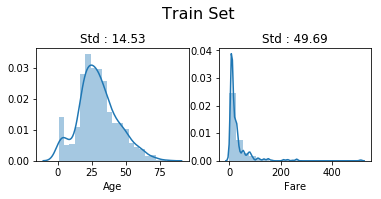

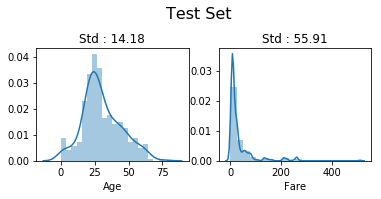

In [6]:
for label,dataset in datasets.items():
    fig,ax=plt.subplots(ncols=2,figsize=(6,2.5))
    fig.suptitle(f'{label} Set',size=16)
    sns.distplot(dataset['Age'],ax=ax[0],bins=20)
    ax[0].set_title("Std : %.2f"%(dataset['Age'].std()))
    sns.distplot(dataset['Fare'],ax=ax[1],bins=20)
    ax[1].set_title("Std : %.2f"%(dataset['Fare'].std()))
    fig.subplots_adjust(top=0.75)

### Creating

- **FamilySize** : This feature is created by adding **SibSp** and **Parch** variables with 1.
- **IsAlone** : This binary feature is created by setting its value to 1 if **FamilySize** is greater than otherwise 0 value is set.
- **Title** : This feature is extracted by the **Name** feature. Moreover, all the Titles whose occurrences is less than 10 are replaced with **'Misc'**.

In [7]:
for label,dataset in datasets.items():
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1
    # Initialize to True/1
    dataset['IsAlone']=1
    dataset['IsAlone'].loc[dataset['FamilySize']>1]=0
    dataset['Title']=dataset.Name.str.extract(" ([A-Za-z]+)\.")
    titleNames=(dataset['Title'].value_counts()<10)
    dataset['Title']=dataset['Title'].apply(lambda title: 'Misc' if titleNames.loc[title]==True else title)

### Completing

- **Cabin** : This feature contains a lot of missing values and cannot be imputed by any means. Hence Cabin feature is dropped from the dataset.
- **Ticket** : This feature contains a lot of duplicates and may not be highly correlated with **Survived** feature. Hence Ticket feature is dropped fromt the dataset.
- **Name** : This feature can be dropped from the dataset as the meaningful information, **Title** has been extracted from this feature.
- **Age** : This feature is imputed with the median values of set grouped by **Pclass** and **Age**.
- **Fare** & **Embarked** : These features are imputed with the mode of these features in the dataset.

In [8]:
for label,dataset in datasets.items():
    count=dataset.isnull().sum().sort_values(ascending=False)
    percentage=(dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)*100
    dtypes=dataset[count.index].dtypes
    missingData=pd.DataFrame({'Count':count,'Percentage':percentage,'Type':dtypes})
    missingData.drop(missingData[missingData['Count']==0].index,inplace=True)
    print('-'*15+label+' Set'+'-'*15,'\n')
    print(missingData,end='\n\n')

---------------Train Set--------------- 

          Count  Percentage     Type
Cabin       687   77.104377   object
Age         177   19.865320  float64
Embarked      2    0.224467   object

---------------Test Set--------------- 

       Count  Percentage     Type
Cabin    327   78.229665   object
Age       86   20.574163  float64
Fare       1    0.239234  float64



In [9]:
for label,dataset in datasets.items():
    dataset.drop(['Cabin','Ticket','Name'],axis=1,inplace=True)
    groups=dataset.groupby(by=['Sex','Pclass'])['Age']
    for index,row in dataset[dataset['Age'].isnull()==True].iterrows():
            dataset.loc[index,'Age']=groups.get_group((row.Sex,row.Pclass)).median()
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)    
    dataset['Fare'].fillna(dataset['Fare'].mode()[0],inplace=True)    
    print(f'# of missing values in {label} Set : {dataset.isnull().sum().max()}')    

# of missing values in Train Set : 0
# of missing values in Test Set : 0


### Converting

We will convert categorical variables to dummy variables for mathematical analysis. There are multiple ways to encode categorical variables; we will use sklearn and pandas function.
- One Hot Encoding **Sex**,**Embarked** and **Title** variables.

In [10]:
for label,dataset in datasets.items():
    datasets[label]=pd.get_dummies(dataset)

In [11]:
datasets['Test'].head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,34.5,0,0,7.8292,1,1,0,1,0,1,0,0,0,0,1,0
1,3,47.0,1,0,7.0000,2,0,1,0,0,0,1,0,0,0,0,1
2,2,62.0,0,0,9.6875,1,1,0,1,0,1,0,0,0,0,1,0
3,3,27.0,0,0,8.6625,1,1,0,1,0,0,1,0,0,0,1,0
4,3,22.0,1,1,12.2875,3,0,1,0,0,0,1,0,0,0,0,1


## Exploratory Data Analysis

#### Using Grouping

In [12]:
features=['Pclass','Sex','SibSp','Parch','Embarked']
for feature in features:
    print(train[[target,feature]].groupby(feature).sum().sort_values(by=target,ascending=False),
          end='\n-----------------------\n')

KeyError: "['Survived'] not in index"

#### Using Visualizations

In [ ]:
grid=sns.FacetGrid(train,col=target)
grid.map(sns.distplot,'Age',bins=20,kde=False)

In [ ]:
grid=sns.FacetGrid(train,row='Pclass',col=target,size=2.2,aspect=1.6)
grid.map(sns.distplot,'Age',bins=20,kde=False)

In [ ]:
grid=sns.FacetGrid(train,col='Embarked',size=2.2,aspect=1.6)
grid.map(sns.pointplot,'Pclass','Survived','Sex')
grid.add_legend()

In [ ]:
grid=sns.FacetGrid(train,col='Embarked',row=target,size=2.2,aspect=1.6)
grid.map(sns.barplot,'Sex','Fare')
grid.add_legend()